In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size) ** 0.5
b1 = torch.randn(n_hidden,                        generator=g) * 0.02
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0


bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden)) 
bnstd_running =  torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # Batch Normalization
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break

  

      0/ 200000: 3.3147


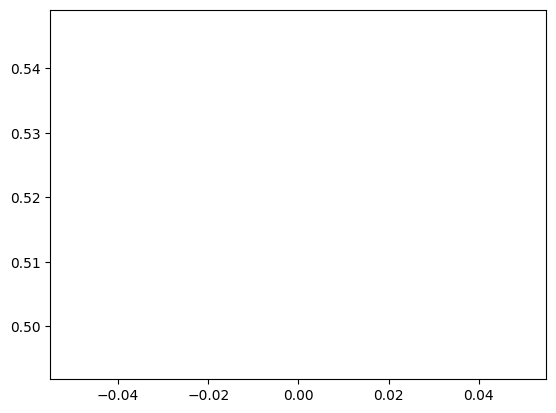

In [8]:
plt.plot(lossi)

In [9]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [10]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1  #+ b1
  hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias 
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.268287420272827
val 3.267815113067627


In [11]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

cbrpzhxqtbfhqvkfkwmrpxqthtykhkcaqskejrzhnbnfqpwsyhc.
vgqhiu.
rrmuqptcmziivdyxlhggphhbmgpoindqbqjtzsrlixwa.
vvdbquwqzthogdjaryxixfkqeupiusdbwed.
ecoia.
gtlffhysflquhpqgmbvdjhksyjrpmqqosozswjcojq.
wycjifrenqkpfsadlnuo.
zoebsrkoiazhrynhg.
opklhynrxyh.
xqioloqbplbvbwdn.
ipvqmuitjpbvfpzpddgpycsislqwkkmconzauqnyjydpk.
kvweskatikzamdtevl.
ky.
qdyctoorowooktbymouokfbfcw.
zoindzcs.
nu.
eoaignqqeroqci.
ipjzykbadyieluglconwzyzdjokhnlhjjqsxmuadltjhvtoyaplwuw.
xisxwrmfv.
qphtzbiuzzsrvgmknbfyntiysfgdglnmmj.


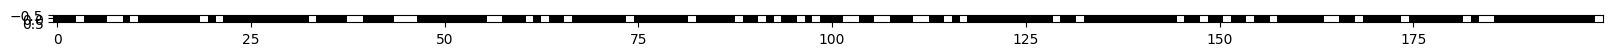

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation='nearest')

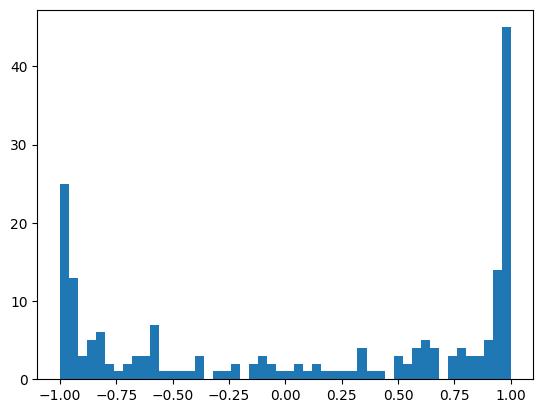

In [13]:
plt.hist(h.view(-1).tolist(), 50);

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [38]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [39]:
class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim) 
        self.running_std = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_std
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_std = (1 - self.momentum) * self.running_std + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

In [40]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(21474)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size) 
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1 
    # apply gain in all other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [42]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
     

      0/ 200000: 2.2896
  10000/ 200000: 1.9484
  20000/ 200000: 2.6681
  30000/ 200000: 2.1056
  40000/ 200000: 2.2685
  50000/ 200000: 2.0842
  60000/ 200000: 2.0493
  70000/ 200000: 2.2082
  80000/ 200000: 1.9966
  90000/ 200000: 2.0967
 100000/ 200000: 2.1067
 110000/ 200000: 1.9774
 120000/ 200000: 2.1933
 130000/ 200000: 2.2394
 140000/ 200000: 2.2043
 150000/ 200000: 1.9010
 160000/ 200000: 1.9298
 170000/ 200000: 1.7107
 180000/ 200000: 1.8390
 190000/ 200000: 1.8736


layer 1 (      Tanh): mean -0.01, std 0.88, saturated: 52.31%
layer 3 (      Tanh): mean +0.04, std 0.90, saturated: 58.34%
layer 5 (      Tanh): mean -0.02, std 0.91, saturated: 59.78%
layer 7 (      Tanh): mean -0.01, std 0.92, saturated: 63.00%
layer 9 (      Tanh): mean +0.02, std 0.83, saturated: 36.41%


Text(0.5, 1.0, 'activation distribution')

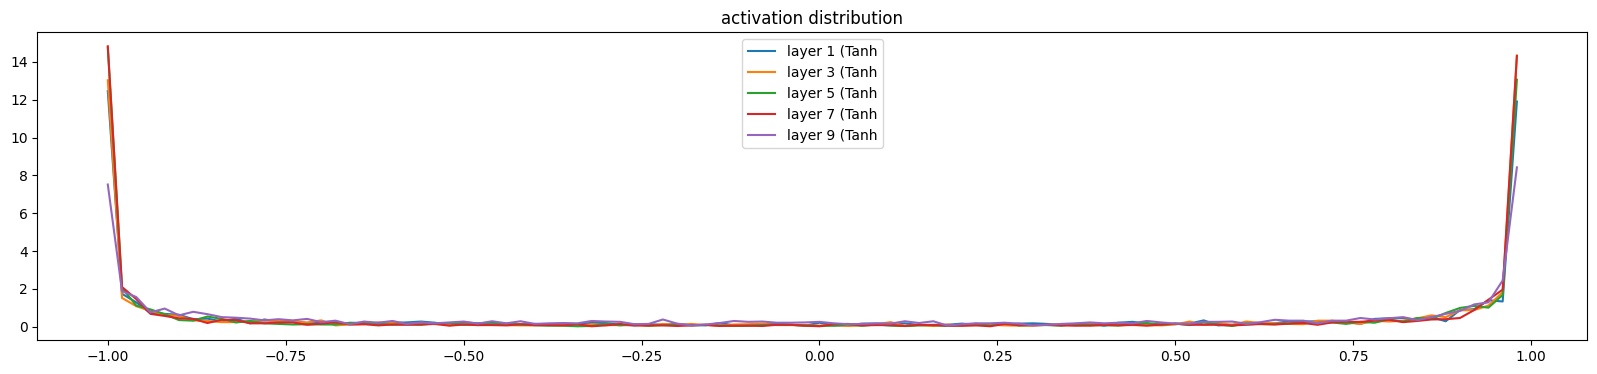

In [43]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000072, std 4.622048e-03
layer 3 (      Tanh): mean -0.000010, std 4.130089e-03
layer 5 (      Tanh): mean +0.000011, std 4.005224e-03
layer 7 (      Tanh): mean +0.000014, std 4.398978e-03
layer 9 (      Tanh): mean +0.000132, std 5.128046e-03


Text(0.5, 1.0, 'gradient distribution')

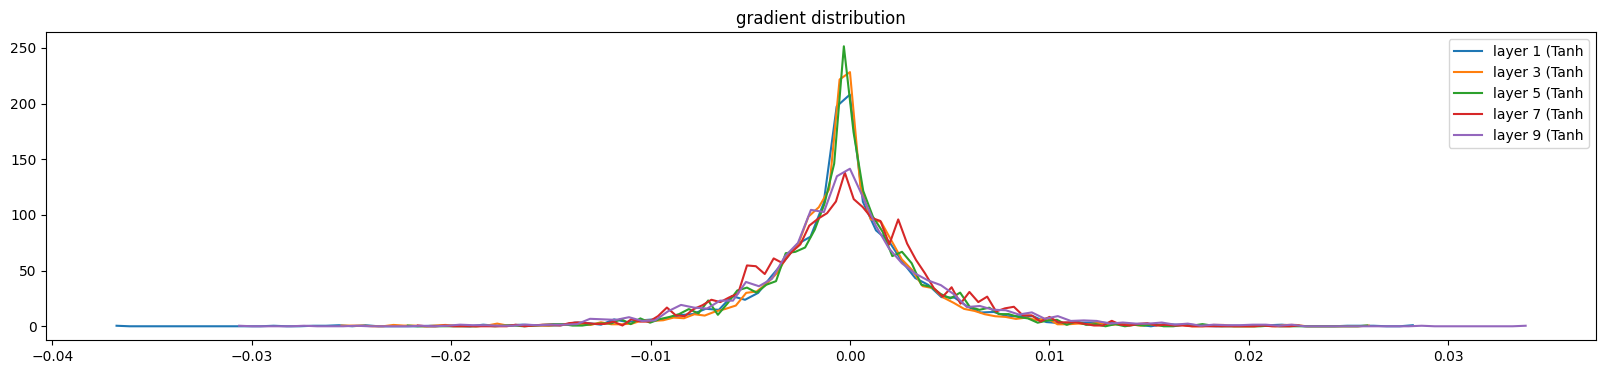

In [44]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000773 | std 1.942904e-02 | grad:data ratio 1.643969e-02
weight  (30, 100) | mean -0.000101 | std 9.885520e-03 | grad:data ratio 1.934726e-02
weight (100, 100) | mean -0.000053 | std 7.286689e-03 | grad:data ratio 2.381456e-02
weight (100, 100) | mean -0.000119 | std 6.767103e-03 | grad:data ratio 2.292448e-02
weight (100, 100) | mean -0.000015 | std 6.678429e-03 | grad:data ratio 2.327682e-02
weight (100, 100) | mean -0.000016 | std 8.015340e-03 | grad:data ratio 3.254677e-02
weight  (100, 27) | mean -0.000000 | std 2.704717e-02 | grad:data ratio 1.386048e-01


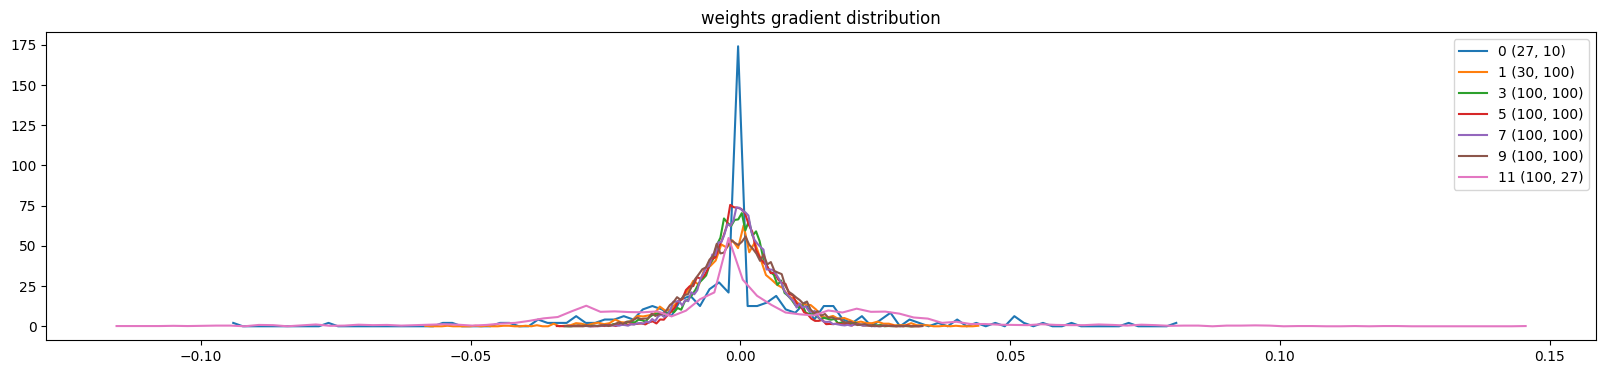

In [45]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [46]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9582678079605103
val 2.084232807159424


In [47]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
amelle.
khyriel.
reet.
khalaysie.
rahmel.
deliah.
jareeic.
ramsia.
chaily.
kaleigh.
ham.
port.
quintis.
lilah.
jadilyn.
jero.
dearyxix.
kaellissa.
mel.
